In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [2]:
def denoise(X, y, n_neighbors = 3):
    """
    Given a set of predictors and targets, determines which class is the minority and then looks for members
    of the minority class for which the closest neighbors are all in the majority. Those elements will be
    pruned from the set.
    """
    # Identify the classes and how many of each exist.
    classes, class_counts = np.unique(y, return_counts = True)
    print(f"Classes: {classes}")

    # Determine which class has the lowest representation in the dataset.
    minority_index = np.argmin(class_counts)
    minority_class = classes[minority_index]
    print(f"Minority Class: {minority_class}")
    print(f"Minority Ratio: {class_counts[minority_index] / y.size}")

    # Build a model representing the nearest neighbors and set up a list to cache the points that are noise.
    knn = NearestNeighbors(n_neighbors = n_neighbors + 1).fit(X)
    noise = []
    
    # Identify which data points represent the minority.
    minority_indices = np.where(y == minority_class)

    # Get the indices of the closest neighbors for each minority sample and then loop over the collection.
    ind = knn.kneighbors(X[minority_indices], return_distance = False)
    for test_index in np.arange(len(ind)):
        # Ignore the closest neighbor because that's the point itself.
        neighbor_indices = ind[test_index][1:]

        # Check for all of the others to _not_ be in the minority class and add to the noise list if that's the case.
        if np.all([y[i] != minority_class for i in neighbor_indices]):
            noise.append(test_index)

    print(f"Noisy samples: {np.array(noise)}")
    return np.delete(X, noise, axis = 0), np.delete(y, noise, axis = 0)

In [3]:
def get_category_indices(X, y, n_neighbors = 3):
    """
    Determine and return the sets of indices representing the minority, the boundary majority, and the remaining majority.
    """
    # Identify the classes and how many of each exist.
    classes, class_counts = np.unique(y, return_counts = True)
    print(f"Classes: {classes}")

    # Determine which class has the lowest representation in the dataset.
    minority_index = np.argmin(class_counts)
    minority_class = classes[minority_index]
    print(f"Minority Class: {minority_class}")
    print(f"Minority Ratio: {class_counts[minority_index] / y.size}")

    # Build a model representing the nearest neighbors and set up a list to cache the points that are noise.
    knn = NearestNeighbors(n_neighbors = n_neighbors + 1).fit(X)

    # Get the minority indices ... that's the easy one.
    minority_indices = np.where(y == minority_class)
    
    bmaj = []
    obmaj = []
    majority_indices = np.where(y != minority_class)

    # Get the indices of the closest neighbors for each majority sample and then loop over the collection.
    ind = knn.kneighbors(X, return_distance = False)
    print(ind)
    for test_index in majority_indices[0]:
        # Ignore the closest neighbor because that's the point itself.
        neighbor_indices = ind[test_index][1:]
        if np.any([y[i] == minority_class for i in neighbor_indices]):
            bmaj.append(test_index)
        else:
            obmaj.append(test_index)

    return minority_indices[0], np.array(bmaj), np.array(obmaj)

In [4]:
def sort_majority_samples(X):
    """
    Given a set of samples, return a list of indices into that collection sorted by descending distance to closest neighbor.
    """
    p = len(X[0])
    n = len(X)
    mat = np.zeros((n, n))
    for row in np.arange(n):
        for col in np.arange(n):
            if col == row:
                continue
            sum = np.zeros((p, p))
            for i in np.arange(n):
                q = X[i] - X[col]
                sum += np.outer(q, q)
            S_j = (1.0 / (n - 1)) * sum
            x = X[row] - X[col]
            mat[row, col] = (1.0 / p) * np.abs(np.dot(np.dot(x, np.linalg.inv(S_j)), x))

    # Now the distance between observations i and j is the minimum of mat[i,j] and mat[j,i]
    # For each entry we want to find the distance to its closest neighbor.
    pairs = []
    for obs in np.arange(n):
        row_vals = np.delete(mat[obs, :], obs)
        col_vals = np.delete(mat[:, obs], obs)
        pairs.append([obs, np.min(np.append(row_vals, col_vals))])
    nearest = np.array(pairs)
    sorted_indices = nearest[:, 1].argsort()[::-1]
    return sorted_indices

In [5]:
from sklearn.datasets import make_classification
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.9, 0.1], n_informative=3, n_redundant=1,
                           flip_y=0, n_features=20, n_clusters_per_class=1, n_samples=100, random_state=10)
min_val = np.min(X)
if min_val < 0:
    X += abs(min_val)

In [6]:
X_new, y_new = denoise(X, y)

Classes: [0 1]
Minority Class: 1
Minority Ratio: 0.1
Noisy samples: [2]


In [7]:
import time
start_time = time.time()

minority_indices, boundary_indices, majority_indices = get_category_indices(X_new, y_new)
print(f"Minority: {minority_indices}")
print(f"Boundary: {boundary_indices}")
print(f"Majority: {majority_indices}")
X_minority = X_new[minority_indices]
y_minority = y_new[minority_indices]

X_majority = X_new[majority_indices]
y_majority = y_new[majority_indices]
sorted_majority = sort_majority_samples(X_majority)

X_resampled = np.append(X_minority, X_majority[:len(X_minority)], axis=0)
y_resampled = np.append(y_minority, y_majority[:len(y_minority)], axis=0)

end_time = time.time()
print(f"Resampling completed in {(end_time - start_time):.2f}s.")

print(len(X_resampled))
print(X_resampled)



Classes: [0 1]
Minority Class: 1
Minority Ratio: 0.10101010101010101
[[ 0 58  9 71]
 [ 1 15 30 44]
 [ 2 77 30 29]
 [ 3 13 73 15]
 [ 4 32 83 45]
 [ 5 21 62 11]
 [ 6 59 97 76]
 [ 7 15 62 88]
 [ 8 62 92 63]
 [ 9  0 38 33]
 [10 24 53 93]
 [11  5 58 93]
 [12 44 97  2]
 [13  3 73 39]
 [14 62 24 79]
 [15  3  7  1]
 [16 63 26 50]
 [17 97 80 38]
 [18 90 52 74]
 [19 60 50 32]
 [20 10 82 77]
 [21  5 46 90]
 [22 72 35 77]
 [23 44 29 84]
 [24 63 10 47]
 [25 97 61 37]
 [26 59 97 44]
 [27 45 52 62]
 [28 76 62 68]
 [29 23 68 44]
 [30  2 77 49]
 [31 44 84 26]
 [32  4 48 19]
 [33 61 38 40]
 [34 30 53 37]
 [35 96 38 55]
 [36 28 21  6]
 [37 61 92 11]
 [38 40 50 33]
 [39 13  3 73]
 [40 38 33 31]
 [41 65 10 18]
 [42 90 93 86]
 [43 46 81 28]
 [44 23 29 31]
 [45 61 58 56]
 [46 43 60 21]
 [47 77 24 48]
 [48 77 53 46]
 [49 68 96 21]
 [50 38 26 53]
 [51 31 84 53]
 [52 74 18 27]
 [53 50 48 61]
 [54  4 72 83]
 [55 35 49 67]
 [56 45 61 79]
 [57 83 61  6]
 [58  0 87 45]
 [59 26 50 97]
 [60 19 46 48]
 [61 83 33 92]
 

# Okay, now for real...

Classes: [0 1]
Minority Class: 1
Minority Ratio: 0.105
Noisy samples: []
Classes: [0 1]
Minority Class: 1
Minority Ratio: 0.105
[[  0 414 143 771]
 [  1 313 138 525]
 [  2 760 276 700]
 ...
 [797   7 231 672]
 [798 329 654 342]
 [799 161 775 539]]
F-score: 1.0


<Figure size 1000x800 with 0 Axes>

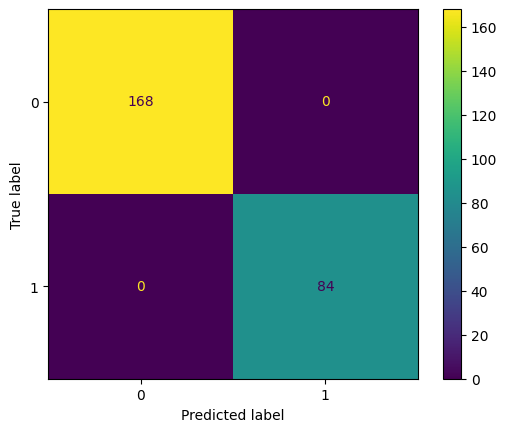

<Figure size 1000x800 with 0 Axes>

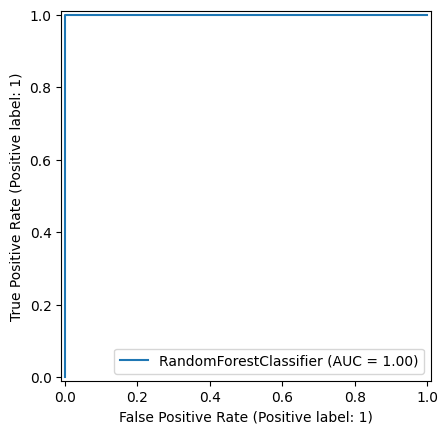

In [8]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = make_classification(n_classes=2, class_sep=2, weights=[0.9, 0.1], n_informative=3, n_redundant=1,
                           flip_y=0, n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
model = RandomForestClassifier()
scaler = MinMaxScaler()

scaler.fit_transform(X_train)

X_new, y_new = denoise(X_train, y_train)
minority_indices, boundary_indices, majority_indices = get_category_indices(X_new, y_new)

X_minority = X_new[minority_indices]
y_minority = y_new[minority_indices]

X_majority = X_new[majority_indices]
y_majority = y_new[majority_indices]
sorted_majority = sort_majority_samples(X_majority)

X_resampled = np.append(X_minority, X_majority[:2 * len(X_minority)], axis=0)
y_resampled = np.append(y_minority, y_majority[:2 * len(y_minority)], axis=0)

model.fit(X_resampled, y_resampled)
y_train_pred = model.predict(X_resampled)

print(f"F-score: {fbeta_score(y_resampled, y_train_pred, beta = 2)}")

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_resampled, y_train_pred)
plt.show()
plt.figure(figsize=(10, 8))
RocCurveDisplay.from_estimator(model, X_resampled, y_resampled)
plt.show()

In [9]:
print(minority_indices, boundary_indices, majority_indices)

[ 11  42  46  57  75  81  91 115 118 145 147 151 153 161 164 166 168 182
 193 221 225 229 241 249 250 251 258 261 268 269 279 281 282 286 288 300
 309 318 326 330 336 346 347 361 368 374 384 405 417 444 445 454 482 484
 493 531 534 539 543 573 577 591 596 598 611 614 638 641 657 662 667 674
 680 685 694 735 749 751 755 774 775 788 793 799] [ 90 223 297] [  0   1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  43  44  45  47  48  49  50  51  52  53  54  55  56
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  76
  77  78  79  80  82  83  84  85  86  87  88  89  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 116
 117 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 146 148 149 150 152 154 155 156 157
 158 159 160 162 163 165 167 169 170 171 172 173 174 175 176

F-score: 0.36036036036036034


<Figure size 1000x800 with 0 Axes>

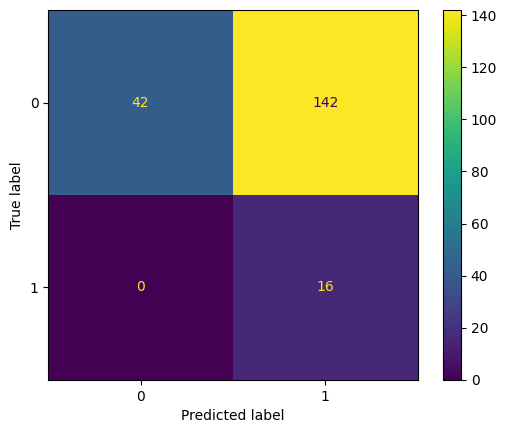

<Figure size 1000x800 with 0 Axes>

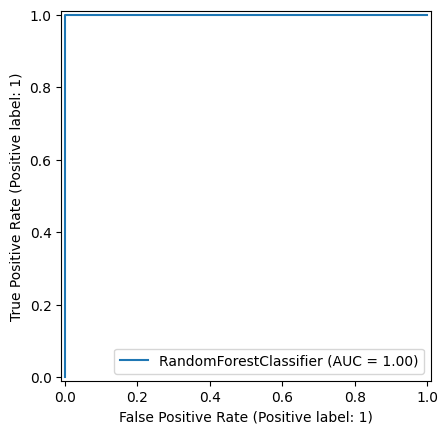

In [10]:
y_test_pred = model.predict(scaler.transform(X_test))

print(f"F-score: {fbeta_score(y_test, y_test_pred, beta = 2)}")

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.show()
plt.figure(figsize=(10, 8))
RocCurveDisplay.from_estimator(model, scaler.transform(X_test), y_test)
plt.show()

<Figure size 1000x800 with 0 Axes>

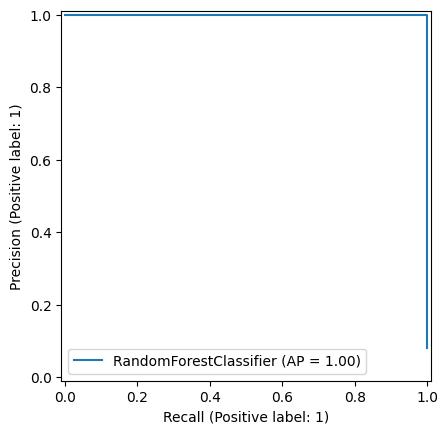

In [11]:
from sklearn.metrics import PrecisionRecallDisplay
plt.figure(figsize=(10, 8))
PrecisionRecallDisplay.from_estimator(model, scaler.transform(X_test), y_test)
plt.show()